# MNIST Classifier
Training a basic feedforward neural network to classify handwritten
digits from the MNIST database

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import os
# from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

In [2]:
# n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
# log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

**Define the Neural Network**

We have opted to use a very simple feedforward neural network. This network has an input layer
which has a size of 784, where each neuron will correspond to a pixel in the image.
Then a hidden layer which was arbitrarily chosen to have 196 neurons (784/4), and finally the
output layer which has 10 neurons corresponding to the 10 classes (digits 0-9).

In [4]:
# Create the neural network
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [24]:
input_size = 784 # 28x28 pixel images
hidden_size = 196 # 1/4 the input size (picked arbitrarily)
num_classes = 10 # 10 classes (digits 0 - 9)
model = NeuralNet(input_size, hidden_size, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

100%|██████████| 938/938 [00:10<00:00, 87.38it/s]


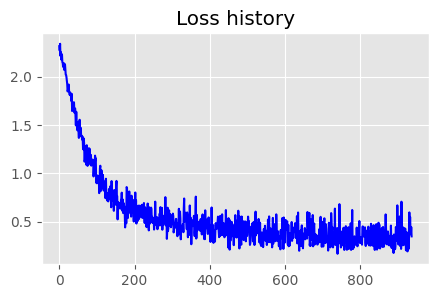

In [25]:
loss_hist = []
for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    model.train()
    optimizer.zero_grad()

    # Do a forward pass to get a prediction from the model
    pred = model(data)

    # Compute the loss
    loss = criterion(pred, target)
    loss_hist.append(loss.item())

    # Compute gradients and take a gradient step
    loss.backward()
    optimizer.step()

# plot the loss history
fig, ax = plt.subplots(figsize=(5,3));
ax.plot(loss_hist, color="blue");
ax.set(title="Loss history");


**Testing**

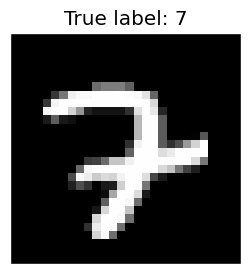

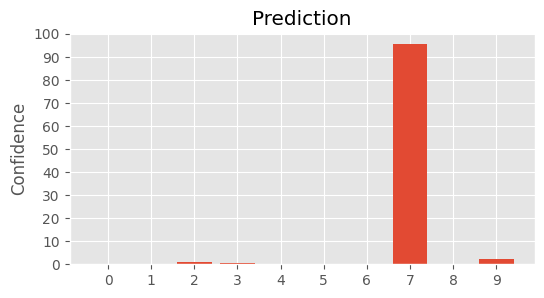

In [26]:
model.eval()

test_data = enumerate(test_loader)
batch_idx, (test_data, test_labels) = next(test_data)
test_img = test_data[0]

# Show the image
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(test_img.squeeze(), cmap='gray')
ax.set(title=f"True label: {test_labels[0]}")
ax.set_xticks([])
ax.set_yticks([])

# Run the image through the model
res = model(test_img).detach()
res = F.softmax(res, dim=1).numpy().flatten()
res_dict = {i : 100*res[i] for i in range(len(res))}

# Bar graph of the predicted class
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(res_dict.keys(), res_dict.values())
ax.set(title="Prediction", ylabel="Confidence")
ax.set_xticks(np.arange(0,10,1));
ax.set_yticks(np.arange(0,110,10));